##### This is a Databricks notebook to work with native SQL
- You can modify this to work with local and avoid file uploading

In [0]:
from pyspark.sql.functions import col

match = spark.read.format("delta").load(
    "/Volumes/workspace/gold/gold_data_files/gold.db/player_match_stats"
)

row_count = (
    match
    .count()
)

print(f"Number of rows: {row_count}")

Number of rows: 671942


In [0]:
# --- FINAL SCRIPT: Create/Replace Managed Tables from Volume Staging Area ---

# 1. Configuration
CATALOG_NAME = "workspace"
SCHEMA_NAME = "gold"
VOLUME_NAME = "gold_data_files"
DATABASE_FOLDER_NAME_IN_VOLUME = "gold.db"

# 2. Define the path to the source data uploaded by your local script
staging_path = f"/Volumes/{CATALOG_NAME}/{SCHEMA_NAME}/{VOLUME_NAME}/{DATABASE_FOLDER_NAME_IN_VOLUME}"

print(f"Starting ETL process from staging area: {staging_path}")
print("This will create or replace fully managed tables.")

try:
    # Get a list of all table directories in the staging area
    table_directories = [item for item in dbutils.fs.ls(staging_path) if item.isDir()]
    
    if not table_directories:
        raise Exception(f"No table subdirectories found in staging path '{staging_path}'. Please ensure the upload was successful.")

    print(f"\nFound {len(table_directories)} tables to process.")
    
    # Ensure the target schema exists. This is idempotent.
    spark.sql(f"CREATE SCHEMA IF NOT EXISTS {CATALOG_NAME}.{SCHEMA_NAME}")

    # Loop through each directory and perform the data copy
    for table_dir in table_directories:
        table_name = table_dir.name.strip('/')
        
        # The source path for a `SELECT` statement (without the 'dbfs:' scheme)
        source_data_location = table_dir.path.replace('dbfs:', '')
        
        print(f"  - Processing '{table_name}'...")
        
        # This is the most robust command for this workflow.
        # - CREATE OR REPLACE TABLE: Handles both the first run and subsequent runs seamlessly.
        # - AS SELECT ...: Copies the data from the staging area into the new managed table.
        # - We use delta.`/path/` to explicitly tell Spark to read the source files as a Delta table.
        create_or_replace_sql = f"""
          CREATE OR REPLACE TABLE {CATALOG_NAME}.{SCHEMA_NAME}.{table_name}
          AS SELECT * FROM delta.`{source_data_location}`
        """
        
        spark.sql(create_or_replace_sql)
        print(f"    -> Successfully created/replaced managed table '{CATALOG_NAME}.{SCHEMA_NAME}.{table_name}'.")
        
    print("\n✅ ETL process complete. All managed tables are up to date.")

except Exception as e:
    print(f"\n❌ An error occurred during the ETL process: {e}")

Starting ETL process from staging area: /Volumes/workspace/gold/gold_data_files/gold.db
This will create or replace fully managed tables.

Found 9 tables to process.
  - Processing 'dim_players'...
    -> Successfully created/replaced managed table 'workspace.gold.dim_players'.
  - Processing 'dim_stages'...
    -> Successfully created/replaced managed table 'workspace.gold.dim_stages'.
  - Processing 'dim_teams'...
    -> Successfully created/replaced managed table 'workspace.gold.dim_teams'.
  - Processing 'match_events'...
    -> Successfully created/replaced managed table 'workspace.gold.match_events'.
  - Processing 'match_summary'...
    -> Successfully created/replaced managed table 'workspace.gold.match_summary'.
  - Processing 'player_match_stats'...
    -> Successfully created/replaced managed table 'workspace.gold.player_match_stats'.
  - Processing 'player_team_season_stats'...
    -> Successfully created/replaced managed table 'workspace.gold.player_team_season_stats'.
  -

In [0]:
%sql
SHOW TABLES IN workspace.gold;

database,tableName,isTemporary
gold,dim_players,false
gold,dim_stages,false
gold,dim_teams,false
gold,match_events,false
gold,match_summary,false
gold,player_match_stats,false
gold,player_team_season_stats,false
gold,team_match_stats,false
gold,team_season_stats,false
,_sqldf,true


In [0]:
%sql USE workspace.gold

In [0]:
%sql
SELECT * FROM dim_stages
LIMIT 5;

stage_id,region_id,region_name,tournament_id,tournament_name,season_id,season_name,stage_name,crawled_at,league,season
5975,247,International,124,European Championship,3164,2012,EURO Quarter finals,2025-09-05T07:06:28.000Z,international-european-championship,2012
5976,247,International,124,European Championship,3164,2012,EURO Semi finals,2025-09-05T07:06:38.000Z,international-european-championship,2012
5978,247,International,124,European Championship,3164,2012,EURO Final,2025-09-05T07:06:45.000Z,international-european-championship,2012
5980,247,International,124,European Championship,3164,2012,EURO Grp. A,2025-09-05T07:06:00.000Z,international-european-championship,2012
5981,247,International,124,European Championship,3164,2012,EURO Grp. B,2025-09-05T07:06:06.000Z,international-european-championship,2012


In [0]:
%sql
SELECT * FROM match_events
WHERE match_id = 1911328
ORDER BY _event_id
LIMIT 50

match_id,_event_id,event_id,team_id,player_id,minute,second,period_value,type_display_name,is_successful,x,y,end_x,end_y,satisfied_events_types_names
1911328,1,2,304,null,0,0,1,start,true,0.0,0.0,null,null,List()
1911328,2,2,246,null,0,0,1,start,true,0.0,0.0,null,null,List()
1911328,3,3,246,547648,0,0,1,pass,true,50.2,50.1,31.2,35.8,"List(touches, pass_accurate, short_pass_accurate, pass_back, pass_right, defensive_third, pos)"
1911328,4,4,246,400646,0,3,1,pass,false,31.8,36.0,73.1,84.7,"List(touches, pass_inaccurate, pass_long_ball_inaccurate, pass_forward, pass_left, final_third, pos)"
1911328,5,42,246,430297,0,5,1,aerial,true,73.0,86.6,null,null,"List(duel_aerial_won, offensive_duel)"
1911328,6,67,304,399826,0,5,1,aerial,false,27.0,13.4,null,null,"List(duel_aerial_lost, defensive_duel)"
1911328,7,43,246,430297,0,5,1,ball_touch,true,73.3,90.7,null,null,List(touches)
1911328,8,3,304,320834,0,9,1,ball_recovery,true,22.9,13.3,null,null,List(ball_recovery)
1911328,9,4,304,320834,0,10,1,pass,true,22.9,13.3,6.4,42.9,"List(touches, pass_accurate, short_pass_accurate, pass_back, pass_left, defensive_third, pos)"
1911328,10,5,304,398299,0,14,1,pass,true,12.5,47.1,14.4,70.3,"List(touches, pass_accurate, short_pass_accurate, pass_forward, pass_left, defensive_third, pos)"


In [0]:
%sql
DESCRIBE player_match_stats

col_name,data_type,comment
match_id,int,null
player_id,int,null
player_name,string,null
shirt_no,int,null
is_starting_eleven,boolean,null
position,string,null
minutes_played,int,null
goals_scored,bigint,null
extra_time_goals,bigint,null
assists,bigint,null


In [0]:
%sql
SELECT * FROM player_match_stats
WHERE goals_scored > 3
ORDER BY goals_scored DESC


match_id,player_id,player_name,shirt_no,is_starting_eleven,position,minutes_played,goals_scored,extra_time_goals,assists,goals_six_yard_box,goals_penalty_area,goals_out_of_box,goals_right_foot,goals_left_foot,goals_head,goals_other_body_parts,goals_open_play,goals_counter,goals_set_piece,own_goals,penalties_taken,penalties_scored,pso_penalties_taken,pso_penalties_scored,yellow_cards,second_yellow_cards,red_cards,total_passes,accurate_passes,key_passes,possession,possession_percentage,total_touches,unsuccessful_touches,total_crosses,accurate_crosses,accurate_long_balls,total_long_balls,accurate_through_balls,total_through_balls,final_third_passes,progressive_passes,progressive_carries,total_shots,total_shots_on_target,total_shots_off_target,total_woodwork_shots,total_shots_blocked,dribbles_won,dribbles_attempted,aerials_total,aerials_won,offensive_aerials,defensive_aerials,tackles_attempted,successful_tackles,dribbled_past,last_man_tackles,clearances,clearances_off_the_line,interceptions_won,blocked_shots,recoveries,corners_won,corners_conceded,corners_taken,accurate_corners,corners_leading_to_goal,dispossessed,fouls_committed,was_fouled,errors,errors_lead_to_shot,errors_lead_to_goal,offsides,total_saves,collected_saves,parried_saves,parried_danger_saves,successful_claims,total_claims,total_punches,total_smother,keeper_sweepers_won,keeper_sweepers_lost,official_penalties_faced,official_penalties_saved,official_penalties_conceded,pso_penalties_faced,pso_penalties_saved,pso_penalties_conceded,start_time_utc,team_id,team_name,opposing_team_id,opposing_team_name,is_home,team_score,opposing_team_score,region_name,region_id,tournament_name,tournament_id,season_name,season_id,stage_name,stage_id
1874117,315227,Erling Haaland,9,true,FW,90,5,0,2,0,5,0,0,4,1,0,2,2,1,0,0,0,0,0,0,0,0,19,16,2,20,2.11,38,1,1,0,1,1,0,0,7,1,3,10,7,2,1,1,3,3,3,2,2,1,1,0,1,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2025-09-09T18:45:00.000Z,334,Norway,818,Moldova,true,11,1,International,247,World Cup Qualification UEFA,721,2025/2026,10555,World Cup Qualification UEFA 1st Round Grp. I,23976
1294630,315755,Luka Jovic,8,true,FW,86,5,0,0,0,5,0,1,3,1,0,4,1,0,0,0,0,0,0,0,0,0,32,25,0,33,3.38,50,3,1,0,0,0,0,0,2,0,1,6,6,0,0,0,2,3,3,2,3,0,0,0,0,0,0,0,0,0,5,1,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-10-19T18:30:00.000Z,45,Eintracht Frankfurt,1150,Fortuna Duesseldorf,true,7,1,Germany,81,Bundesliga,3,2018/2019,7405,1. Bundesliga,16427
969611,29400,Robert Lewandowski,9,false,FW,44,5,0,0,0,4,1,4,1,0,0,5,0,0,0,0,0,0,0,0,0,0,18,15,1,18,1.44,30,3,0,0,1,1,0,0,9,0,2,9,7,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015-09-22T18:00:00.000Z,37,Bayern Munich,33,Wolfsburg,true,5,1,Germany,81,Bundesliga,3,2015/2016,5870,1. Bundesliga,12559
985478,5583,Cristiano Ronaldo,7,true,AML,90,5,0,1,1,4,0,4,1,0,0,3,1,0,0,1,1,0,0,0,0,0,29,21,3,32,3.24,43,1,3,0,0,0,0,0,8,0,5,7,5,2,0,0,0,0,3,1,3,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,1,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015-09-12T14:00:00.000Z,52,Real Madrid,70,Espanyol,false,6,0,Spain,206,LaLiga,4,2015/2016,5933,Primera Division,12647
1694368,315227,Erling Haaland,9,true,FW,63,5,0,0,2,3,0,2,2,1,0,1,0,3,0,1,1,0,0,0,0,0,16,11,1,16,1.57,30,1,0,0,0,0,0,0,8,0,3,8,8,0,0,0,2,2,3,3,2,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2023-03-14T20:00:00.000Z,167,Manchester City,7614,RB Leipzig,true,7,0,Europe,250,Champions League,12,2022/2023,9086,Champions League Final Stage,20969
1139118,9294,Aritz Aduriz,20,true,FW,90,5,0,0,1,4,0,4,1,0,0,2,0,0,0,3,3,0,0,0,0,0,24,13,0,26,3.12,47,3,2,0,1,2,0,0,4,2,2,10,5,4,0,1,1,1,8,5,8,0,1,1,0,0,1,0,0,0,3,2,0,0,0,0,1,4,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-11-03T18:00:00.000Z,53,Athletic Club,140,Genk,true,5,3,Europe,250,Europa League,30,2016/2017,6275,Europa League Grp. F,14182
959810,14260,Sergio Agüero,10,true,FW,66,5,0,0,2,1,2,3,1,1,0,4,0,1,0,0,0,0,0,0,0,0,18,14,0,18,1.87,36,1,0,0,0,0,0,0,8,0,3,8

In [0]:
%sql
describe player_team_season_stats

col_name,data_type,comment
player_id,int,null
player_name,string,null
tournament_name,string,null
tournament_id,int,null
season_name,string,null
season_id,int,null
appearances,bigint,null
games_started,bigint,null
minutes_played,bigint,null
goals_scored,bigint,null


In [0]:
%sql
SELECT
  player_name,
  SUM(goals_scored) AS total_goals,
  SUM(minutes_played) AS total_minutes,
  ROUND(SUM(total_shots) * (90.0 / SUM(minutes_played)), 2) AS shots_per_90,
  ROUND(SUM(total_shots) / NULLIF(SUM(goals_scored), 0), 2) AS shots_per_goal,
  COUNT(DISTINCT tournament_name) AS num_leagues,
  COLLECT_SET(tournament_name) AS leagues_played
FROM player_team_season_stats
WHERE tournament_name IN ('Bundesliga', 'Premier League', 'LaLiga', 'Serie A', 'Ligue 1')
  AND season_name = '2024/2025'
GROUP BY player_name
ORDER BY total_goals DESC, total_minutes DESC
LIMIT 50

player_name,total_goals,total_minutes,shots_per_90,shots_per_goal,num_leagues,leagues_played
Kylian Mbappé,31,2918,4.97,5.19,1,List(LaLiga)
Mohamed Salah,29,3380,3.46,4.48,1,List(Premier League)
Robert Lewandowski,27,2686,3.85,4.26,1,List(LaLiga)
Harry Kane,26,2399,4.28,4.38,1,List(Bundesliga)
Mateo Retegui,25,2424,3.86,4.16,1,List(Serie A)
Alexander Isak,23,2774,3.21,4.3,1,List(Premier League)
Erling Haaland,22,2742,3.54,4.91,1,List(Premier League)
Omar Marmoush,22,2648,4.28,5.73,2,"List(Bundesliga, Premier League)"
Ante Budimir,21,2983,2.99,4.71,1,List(LaLiga)
Mason Greenwood,21,2828,3.82,5.71,1,List(Ligue 1)


Databricks visualization. Run in Databricks to view.

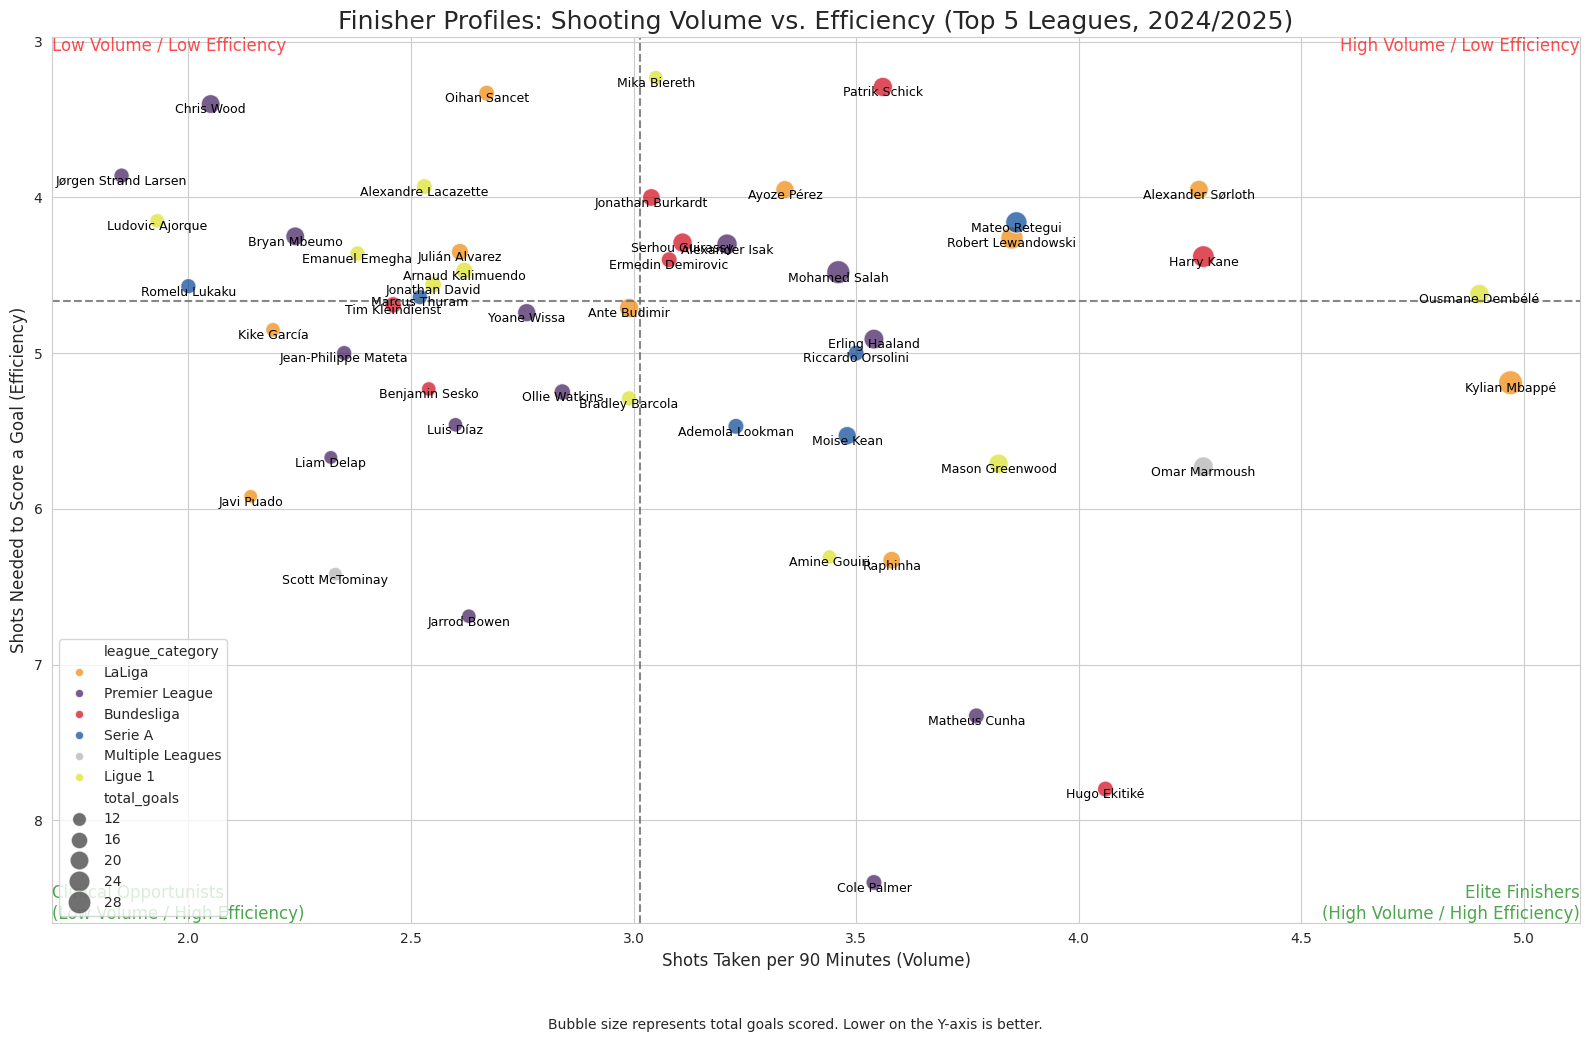

In [0]:
df = _.toPandas()
import numpy as np

# --- 2. CREATE THE CUSTOM HUE CATEGORY (THE CRITICAL NEW LOGIC) ---
# This function checks the new columns from our SQL query and assigns a category.
def get_league_category(row):
    if row['num_leagues'] > 1:
        return 'Multiple Leagues' # This is our "6th hue"
    elif row['num_leagues'] == 1:
        return row['leagues_played'][0] # Get the single league name from the list
    else:
        return 'Unknown'

# Apply this function to create the new column for plotting
df['league_category'] = df.apply(get_league_category, axis=1)
df['goals_scaled'] = np.sqrt(df['total_goals']) # Renamed to match new SQL output
# ------------------------------------------------------------------------

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Define a custom color palette for consistency
league_colors = {
    'Premier League': '#3D195B',
    'LaLiga': '#EE8707',
    'Bundesliga': '#D20515',
    'Serie A': '#024494',
    'Ligue 1': '#DAE025',
    'Multiple Leagues': '#B0B0B0' # A neutral grey for players who moved
}


# --- CHART CONFIGURATION ---
sns.set_style("whitegrid")
plt.figure(figsize=(16, 11))

# 2. Create the Scatter Plot with IMPROVED SIZING
plot = sns.scatterplot(
    data=df,
    x='shots_per_90',
    y='shots_per_goal',
    size='total_goals', # USE THE NEW SCALED COLUMN FOR SIZE
    sizes=(100, 300),    # Adjust the min/max size for a better visual feel
    alpha=0.7,
    hue='league_category', # USE THE NEW HUE COLUMN
    palette=league_colors, # Apply our custom colors
    legend='brief',
)


# --- ANNOTATION AND ANALYSIS ---

# 3. Add Quadrant Lines (Using Median - Statistically Robust)
x_median = df['shots_per_90'].median()
y_median = df['shots_per_goal'].median()

plt.axvline(x=x_median, color='dimgray', linestyle='--', linewidth=1.5, alpha=0.8)
plt.axhline(y=y_median, color='dimgray', linestyle='--', linewidth=1.5, alpha=0.8)

# 4. MARK THE 4 CORNERS (NEW)
# Get the limits of the axes to place the text in the corners
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# Note: The Y-axis is inverted, so y_min is visually at the top and y_max is at the bottom.
plt.text(x_max, y_min, "High Volume / Low Efficiency", ha='right', va='top', fontsize=12, color='red', alpha=0.7)
plt.text(x_min, y_min, "Low Volume / Low Efficiency", ha='left', va='top', fontsize=12, color='red', alpha=0.7)
plt.text(x_max, y_max, "Elite Finishers\n(High Volume / High Efficiency)", ha='right', va='bottom', fontsize=12, color='green', alpha=0.7)
plt.text(x_min, y_max, "Clinical Opportunists\n(Low Volume / High Efficiency)", ha='left', va='bottom', fontsize=12, color='green', alpha=0.7)


# 5. Add Player Name Labels (Unchanged)
for i, row in df.iterrows():
    plt.text(
        x=row['shots_per_90'],
        y=row['shots_per_goal'] + 0.06, # Slightly offset text
        s=row['player_name'],
        fontdict=dict(color='black', size=9),
        ha='center' # Center the text horizontally over the dot
    )

# --- FINAL POLISHING ---
plt.gca().invert_yaxis() # Invert Y-axis (lower shots_per_goal is better)

plt.title('Finisher Profiles: Shooting Volume vs. Efficiency (Top 5 Leagues, 2024/2025)', fontsize=18)
plt.xlabel('Shots Taken per 90 Minutes (Volume)', fontsize=12)
plt.ylabel('Shots Needed to Score a Goal (Efficiency)', fontsize=12)
plt.figtext(0.5, 0.01, 'Bubble size represents total goals scored. Lower on the Y-axis is better.', ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})


plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to prevent title/labels from being cut off
plt.show()

In [0]:
%sql
SELECT
  team_name,
  matches,
  possession_percentage AS possession_percentage,
  ROUND(goals_against / matches, 2) AS goals_conceded_per_match
FROM team_season_stats
WHERE tournament_name LIKE "%Champions League%"
  AND season_name = '2023/2024'
  AND team_name IS NOT NULL
ORDER BY goals_conceded_per_match ASC

team_name,matches,possession_percentage,goals_conceded_per_match
Real Sociedad,8,52.3,0.75
Arsenal,10,56.76,0.8
Borussia Dortmund,13,45.33,0.85
Inter,8,52.49,0.88
Bayern Munich,12,54.76,1.08
FC Porto,8,47.95,1.13
Real Madrid,13,53.07,1.15
Newcastle,6,45.7,1.17
Lazio,8,43.88,1.25
Paris Saint-Germain,12,64.6,1.25


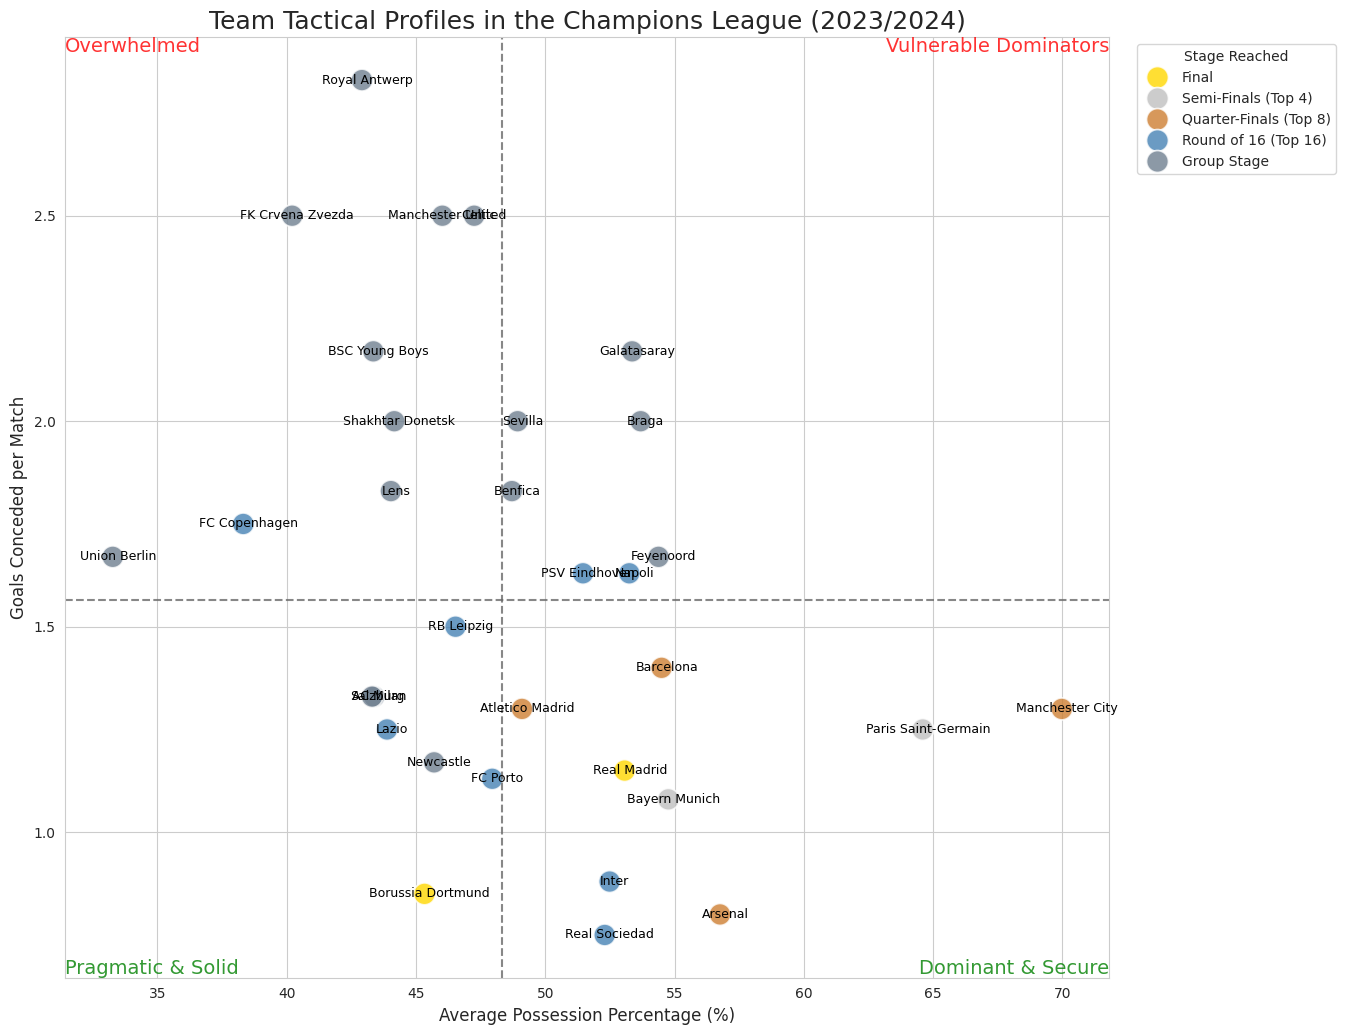

In [0]:
# 1. Load the SQL query results into a Pandas DataFrame
df = _.toPandas()

# Import the necessary plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. CREATE THE CUSTOM COLOR CATEGORY (THE KEY NEW LOGIC) ---
# This function maps the number of matches played to the stage of the competition reached.
def get_stage_reached(matches):
    if matches >= 13: # The two finalists play 13 matches in this format
        return "Final"
    elif matches >= 12:
        return "Semi-Finals (Top 4)"
    elif matches >= 10:
        return "Quarter-Finals (Top 8)"
    elif matches >= 8:
        return "Round of 16 (Top 16)"
    else: # Teams that played 6 matches were eliminated in the Group Stage
        return "Group Stage"

# Apply the function to create a new column in our DataFrame
df['stage_reached'] = df['matches'].apply(get_stage_reached)

# Define a specific color palette for a clear and appealing visual hierarchy
stage_palette = {
    "Final": "#FFD700",        # Gold
    "Semi-Finals (Top 4)": "#C0C0C0",   # Silver
    "Quarter-Finals (Top 8)": "#CD7F32", # Bronze
    "Round of 16 (Top 16)": "#4682B4",  # Steel Blue
    "Group Stage": "#708090"   # Slate Gray
}
# ------------------------------------------------------------------------

# --- CHART CONFIGURATION ---
sns.set_style("whitegrid")
plt.figure(figsize=(16, 11))

# 3. Create the Scatter Plot with the new HUE for color
plot = sns.scatterplot(
    data=df,
    x='possession_percentage',
    y='goals_conceded_per_match',
    s=250,
    alpha=0.8,
    hue='stage_reached',      # Color the dots based on our new category
    palette=stage_palette,    # Apply our custom color scheme
    hue_order=stage_palette.keys() # Ensure the legend is in the correct order
)

# --- ANNOTATION AND ANALYSIS (Unchanged) ---
x_median = df['possession_percentage'].median()
y_median = df['goals_conceded_per_match'].median()
plt.axvline(x=x_median, color='dimgray', linestyle='--', linewidth=1.5, alpha=0.8)
plt.axhline(y=y_median, color='dimgray', linestyle='--', linewidth=1.5, alpha=0.8)

x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.text(x_max, y_min, "Dominant & Secure", ha='right', va='bottom', fontsize=14, color='green', alpha=0.8)
plt.text(x_min, y_min, "Pragmatic & Solid", ha='left', va='bottom', fontsize=14, color='green', alpha=0.8)
plt.text(x_max, y_max, "Vulnerable Dominators", ha='right', va='top', fontsize=14, color='red', alpha=0.8)
plt.text(x_min, y_max, "Overwhelmed", ha='left', va='top', fontsize=14, color='red', alpha=0.8)

for i, row in df.iterrows():
    plt.text(
        x=row['possession_percentage'] + 0.2,
        y=row['goals_conceded_per_match'],
        s=row['team_name'],
        ha='center',
        va='center',
        fontdict=dict(color='black', size=9)
    )

# --- FINAL POLISHING ---
plt.title('Team Tactical Profiles in the Champions League (2023/2024)', fontsize=18)
plt.xlabel('Average Possession Percentage (%)', fontsize=12)
plt.ylabel('Goals Conceded per Match', fontsize=12)

# Update the legend title
h, l = plot.get_legend_handles_labels()
plot.legend(h, l, title="Stage Reached", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 0.95]) # Adjust layout to make space for the legend
plt.show()